In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
from helpers import calculate_mse
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "../data/data_train.csv"
ratings = load_data(path_dataset)

number of items: 10000, number of users: 1000


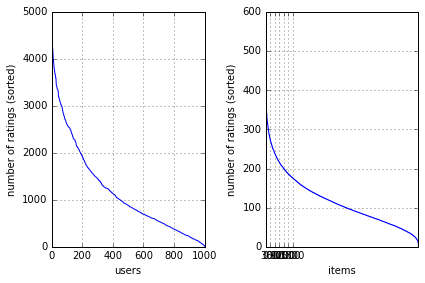

min # of items per user = 8, min # of users per item = 3.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

## Split data into training and test set

In [4]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data and return train and test data. TODO
    # NOTE: we only consider users and movies that have more
    # than 10 ratings
    # generate random indices
    train = sp.lil_matrix((len(valid_items), len(valid_users)))
    test = sp.lil_matrix((len(valid_items), len(valid_users)))
    index_row,index_col = valid_ratings.nonzero()
    for i in np.arange(len(index_row)):
        # train or test
        choice = np.random.choice(a=[1, 2],p=[0.1,0.9])
        if(choice == 1):
            test[index_row[i],index_col[i]] = valid_ratings[index_row[i],index_col[i]]
        else:
            train[index_row[i],index_col[i]] = valid_ratings[index_row[i],index_col[i]]
    # ***************************************************
    #print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    #print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    #print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

In [5]:
from plots import plot_train_test_data

valid_ratings, train_validation, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1)
#plot_train_test_data(train_validation, test)

In [6]:
print(ratings.shape)
print(test.shape)

(10000, 1000)
(10000, 1000)


## Matrix factorisation using SGD-b

In [7]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    num_items, num_users = train.shape
    
    user_features = 0.1* np.ones ((num_features, num_users)) 
    item_features = 0.1*np.ones ((num_features, num_items)) 

    return user_features, item_features
def compute_error_b(data, user_features, item_features, nz, b_u, b_i, b_g):

        # ***************************************************
    real_label = np.array([data[d,n] for (d,n) in nz])
    pred_array = np.dot(item_features.T,user_features) + b_u + b_i + b_g
    prediction = np.array([pred_array[d,n] for (d,n) in nz])
    rmse = np.sqrt((1/len(nz))*calculate_mse(real_label,prediction))
    # ***************************************************
    return rmse

def mean_user(train,test):  
    num_items, num_users = train.shape
    mean =  np.array(train.sum(axis=0)/train.getnnz(axis=0))[0]   
    mean_u = np.ones((num_items,num_users))*mean.T
    return mean_u

def mean_item(train,test):  
    num_items, num_users = train.shape
    mean =  np.array(train.sum(axis=1).T/train.getnnz(axis=1))[0]   
    mean_i = (np.ones((num_items,num_users)).T*mean).T
    return mean_i

def mean_global(train,test):
    num_items, num_users = train.shape
    mean = (train.sum())/train.nnz
    mean_g = np.ones((num_items,num_users))*mean
    return mean_g

In [8]:
def matrix_factorization_SGD_b(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 8   # K in the lecture notes =20
    lambda_user = 0.05
    lambda_item = 0.10
    it = 0    # number of full passes through the train set # use test rmse
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    
    
    b_u = mean_user(train,test)
    b_i = mean_item(train,test)
    b_g = mean_global(train,test)
    

    errors[0] = compute_error_b(train, user_features, item_features, nz_train, b_u, b_i, b_g)
    
    
    num_items, num_users = train.shape
    
    error = 100.5
    error_new = 90.5

    
        
    print("learn the matrix factorization using SGD...")
    while ( error > error_new and it < 10):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        error = error_new
        
        # decrease step size
        gamma /= 1.2
        

        #diff = train.toarray() - item_features.T.dot(user_features)

        for d, n in nz_train:
            
            prediction = item_features[:,d].dot(user_features[:,n])
            #gradient
            prediction_error = (train[d,n] - b_u[d,n] - b_i[d,n] - b_g[d,n] - prediction )
            #print(prediction_error)
            
            
            #gradient entries for W
            gradient_w= -(prediction_error)*(user_features[:,n].T) + lambda_item * (item_features[:,d].T)
            #gradient entries for Z
            gradient_z = -(prediction_error)*(item_features[:,d]) + lambda_user * (user_features[:,n].T)
            
            
            b_u[d,n] += gamma*(prediction_error - lambda_user*b_u[d,n])
            b_i[d,n] += gamma*(prediction_error - lambda_item*b_i[d,n])
            #b_g[d,n] += gamma*(prediction_error - lambda_item*lambda_user*b_g[d,n])
            
            #update
            item_features[:,d] -=  gamma*gradient_w.T
            user_features[:,n] -=  gamma*gradient_z.T

        
        rmse = compute_error_b(train, user_features, item_features, nz_train, b_u, b_i, b_g)

        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        
        error_new = compute_error_b(test, user_features, item_features, nz_test, b_u, b_i, b_g)
        print("iter: {}, RMSE on testing set: {}.".format(it, error_new))
        it += 1
        errors.append(rmse)
    rmse = compute_error_b(test, user_features, item_features, nz_test, b_u, b_i, b_g)
    print("RMSE on test data: {}.".format(rmse))
    pred = item_features.T.dot(user_features)+b_u+b_i+b_g
    return pred,nz_train,nz_test

 

In [9]:
pred,nz_train,nz_test = matrix_factorization_SGD_b(train_validation, test)

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.025554320994228.
iter: 0, RMSE on testing set: 1.0525105297104802.
iter: 1, RMSE on training set: 0.9929783387076588.
iter: 1, RMSE on testing set: 1.0347986363443002.
iter: 2, RMSE on training set: 0.9745832570709049.
iter: 2, RMSE on testing set: 1.0276846366100527.
iter: 3, RMSE on training set: 0.9592558219297654.
iter: 3, RMSE on testing set: 1.0230819646897855.
iter: 4, RMSE on training set: 0.947057829474969.
iter: 4, RMSE on testing set: 1.018272404140875.
iter: 5, RMSE on training set: 0.9385803977848219.
iter: 5, RMSE on testing set: 1.0168919218843726.
iter: 6, RMSE on training set: 0.9303823958459199.
iter: 6, RMSE on testing set: 1.014087180214594.
iter: 7, RMSE on training set: 0.9246874088009948.
iter: 7, RMSE on testing set: 1.0127758768314847.
iter: 8, RMSE on training set: 0.9197812961343997.
iter: 8, RMSE on testing set: 1.0121174671459385.
iter: 9, RMSE on training set: 0.9156110500996683.


In [10]:
def feature_adding(train, test, pred):
    """
    built y = real_labels  tx = (pred, #user ratings, #movie ratings, mean rate per user, mean rate per movie)
    May be also add std deviation
    
    """
    
    num_u = train.getnnz(axis=0)
    num_i = train.getnnz(axis=1)   
    mean_u = np.array(train.sum(axis=0)/num_u)[0]
    mean_i = np.array(train.sum(axis=1).T/num_i)[0]
    
    train_a = train.toarray()
    
    std_u = np.std(train_a, axis=0)
    std_i = np.std(train_a, axis=1)
    
    y = np.array([train[d,n] for (d,n) in nz_train])
    y_test = np.array([test[d,n] for (d,n) in nz_test])
    
    
    tX = np.array([[pred[d,n],num_u[n],num_i[d],mean_u[n],mean_i[d],std_u[n],std_i[d]] for (d,n) in nz_train])
    tX_test = np.array([[pred[d,n],num_u[n],num_i[d],mean_u[n],mean_i[d],std_u[n],std_i[d]] for (d,n) in nz_test])
   
    return y, y_test, tX, tX_test

In [11]:
#least square
def least_squares(y, tx):
    """
    Least squares using normal equations.
    """
    w = np.linalg.solve(tx.T.dot(tx), tx.T.dot(y))
    return w

def error_mse(y, tx, w):
    rmse = np.sqrt((1/len(y))*calculate_mse(y,tx.dot(w)))
    return rmse
def ridge_regression(y, tx):
    """
    Least squares using normal equations (with L2 regularization)
    """
    lambda_ = 0.1
    reg = 2 * y.size * lambda_ * np.identity(tx.shape[1]) # L2 regularization term
    w = np.linalg.solve(tx.T.dot(tx) + reg, tx.T.dot(y))
    return w

In [12]:
def sigmoid(t):
    """
    Apply sigmoid function on t.
    """
    # Here the exp-normalize trick is used to improve numerical stability.
    # See: https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    # The code has been adapted to work with vector notation (i.e. parallel).
    signs = t >= 0
    z = np.exp((1 - signs*2) * t)
    return (z * (1 - signs) + signs) / (1 + z)
    
    
def compute_loss_logistic(y, tx, w):
    """
    Compute the cost by negative log likelihood (for logistic regression).
    """
    # Compute log(1 + exp(tx w)) in a numerically stable way
    a = np.logaddexp(0, tx.dot(w)) # This is equal to log(exp(0) + exp(tx w))
    b = y * tx.dot(w)
    return np.sum(a - b)

def compute_gradient_logistic(y, tx, w):
    """
    Compute the gradient of loss (for logistic regression).
    """
    return tx.T.dot(sigmoid(tx.dot(w)) - y)

def logistic_regression(y, tx, initial_w, max_iters, gamma):
    """
    Logistic regression using batch gradient descent.
    """
    w = initial_w
    threshold = 1e-10 # Threshold for convergence detection
    prev_loss = compute_loss_logistic(y, tx, w)
    for i in range(max_iters):
        w = w - gamma * compute_gradient_logistic(y, tx, w)
        loss = compute_loss_logistic(y, tx, w)
        if prev_loss - loss < threshold:
            break # Convergence detected
        prev_loss = loss
    
    return w

In [13]:
y, y_test, tX, tX_test = feature_adding(train_validation, test, pred)

In [22]:
w = ridge_regression(y, tX)
print(error_mse(y, tX, w))
print(error_mse(y_test, tX_test, w))


0.947502524938
1.0023662484


In [23]:
import itertools
def feature_adding_all(train, test, pred):
    num_u = train.getnnz(axis=0)
    num_i = train.getnnz(axis=1)   
    mean_u = np.array(train.sum(axis=0)/num_u)[0]
    mean_i = np.array(train.sum(axis=1).T/num_i)[0]
    
    train_a = train.toarray()
    
    std_u = np.std(train_a, axis=0)
    std_i = np.std(train_a, axis=1)
    
    ind =  itertools.product(np.arange(train.shape[0]), np.arange(train.shape[1]))
    
    tX = np.array([[pred[d,n],num_u[n],num_i[d],mean_u[n],mean_i[d],std_u[n],std_i[d]] for (d,n) in ind])
   
    return tX

In [24]:
tX_all = feature_adding_all(train_validation, test, pred)

In [25]:
def pred_all(tX_all, w):
    return tX_all.dot(w)

w_nth = np.array([1,0,0,0,0,0,0])
pred_all = pred_all(tX_all, w_nth)


In [26]:
print(pred.shape)
print(ratings.shape)
print(test.shape)
print(pred_all.shape)

(10000, 1000)
(10000, 1000)
(10000, 1000)
(10000000,)


In [27]:
pred_ready = pred_all.reshape((pred.shape[0], pred.shape[1]))
print(pred_ready.shape)
#print(pred)
#print(pred_ready)

(10000, 1000)


In [36]:
def submit_predictions(prediction, outputFilename, sampleSubmissionFilename):
    import csv
    
    ## Read the indices 
    with open(sampleSubmissionFilename,'r') as csvinput:
        reader = csvinput.read().splitlines()
        i=-1
        ind = []
        for row in reader:
            if i != -1:
                pos, rating = row.split(',')
                ind.append(pos)
            i+=1
    ## Create rows to be written
    rows = zip(ind, prediction)

    ## Write prediction with indices
    import csv
    with open(outputFilename, 'w', newline='\n') as f:
        writer = csv.writer(f)
        writer.writerow(['Id','Prediction'])
        for row in rows:
            writer.writerow(row)

In [38]:
##===Load test data====##
print("Loading test data")
path_dataset = "../data/sampleSubmission.csv"
submission_ratings = load_data(path_dataset)



Loading test data
number of items: 10000, number of users: 1000


In [39]:

##====Generate predictions for test data====##
print("Generate predictions")
##all nnz since ==3 
nz_row, nz_col = submission_ratings.nonzero()
nz = list(zip(nz_row, nz_col))
prediction = [pred_ready[d,n] for (d,n) in nz]
prediction = np.round(prediction,10)




Generate predictions


In [40]:
##==== Create submission file=====##
print("Creating submission file")
sampleSubmissionFilename = '../data/sampleSubmission.csv'
outputFilename = 'submit_real.csv'
submit_predictions(prediction, outputFilename, sampleSubmissionFilename)

Creating submission file
